In [281]:
import pandas as pd
import altair as alt
import numpy as np
import matplotlib.pyplot as plt
import re
import upsetplot
from commons import data_processing
from commons import common_objects as co 
from commons import generate_hex
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from commons.APICallers import uniprot

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [3]:
# Define colors used throughout

BROWN = "#604739"
LIGHT_BROWN = "#9A8786"
BLUE_GRAY = "#B3ACB9"
LIGHT_BLUE = "#8B97B9"
BLUE = "#637192"
DARK_BLUE = "#3B4459"

colors = [
    BROWN, LIGHT_BROWN, BLUE_GRAY,
    LIGHT_BLUE, BLUE, DARK_BLUE
]

In [95]:
df = pd.read_parquet(r"./data/DIANN_results/BCaP_6Line_DIANN_report.parquet")

# change column names
df.columns = [c.lower().replace(".", "_") for c in df.columns]

# extract sample name and replicate information from file
def grab_sample_info(s):
    pattern = re.compile(r"BCaP\_([A-Z0-9]+)\-(\d)\_run(\d)")
    match = re.search(pattern, s)    
    return '-'.join(list(match.groups()))
        

info = df.run.map(grab_sample_info)

# split series on '-'
info = info.str.split('-', expand=True)

# rename columns
info.columns = ["sample_name", "bio_rep", "tech_rep"]

# merge into former dataframe
df = df.merge(info, left_index=True, right_index=True)
df.head()

file_name  \
0  D:\Data\DIA-NN\GD_20230404_BCaP\BCaP_BPH1-1_ru...   
1  D:\Data\DIA-NN\GD_20230404_BCaP\BCaP_BPH1-1_ru...   
2  D:\Data\DIA-NN\GD_20230404_BCaP\BCaP_BPH1-3_ru...   
3  D:\Data\DIA-NN\GD_20230404_BCaP\BCaP_M1-1_run1...   
4  D:\Data\DIA-NN\GD_20230404_BCaP\BCaP_M1-1_run2...   

                        run protein_group protein_ids protein_names    genes  \
0  BCaP_BPH1-1_run1_1_1_908        P55011      P55011   S12A2_HUMAN  SLC12A2   
1  BCaP_BPH1-1_run2_1_1_909        P55011      P55011   S12A2_HUMAN  SLC12A2   
2  BCaP_BPH1-3_run1_1_1_914        P55011      P55011   S12A2_HUMAN  SLC12A2   
3    BCaP_M1-1_run1_1_1_953        P55011      P55011   S12A2_HUMAN  SLC12A2   
4    BCaP_M1-1_run2_1_1_954        P55011      P55011   S12A2_HUMAN  SLC12A2   

   pg_quantity  pg_normalised  pg_maxlfq  genes_quantity  ...  ptm_q_value  \
0      9598.63        10854.8    12006.9         9598.63  ...          0.0   
1      9068.59        10110.2    10812.6         9068.59  ...          0.0   
2     10028.50        11783.6    12627.2        10028.50  ...          0.0   
3     17645.40        17007.8    15965.9        17645.40  ...          0.0   
4     14797.90        14952.7    16692.0        14797.90  ...          0.0   

   ptm_site_confidence  lib_ptm_site_confidence       im      iim  \
0             0.995124                 0.999917  1.06292  1.06542   
1             0.999772                 0.999917  1.06591  1.06542   
2             0.000000                 0.999917  1.07455  1.06542   
3             0.999772                 0.999917  1.03542  1.06542   
4             0.995467                 0.999917  1.04500  1.06542   

  predicted_im  predicted_iim  sample_name  bio_rep  tech_rep  
0      1.07996        1.04615         BPH1        1         1  
1      1.08115        1.04861         BPH1        1         2  
2      1.08134        1.05721         BPH1        3         1  
3      1.05679        1.04328           M1        1         1  
4      1.06361        1.04517           M1        1         2  

[5 rows x 65 columns]

In [99]:
# define overall sample order
bcap_order = [
    "BPH1-1", "BPH1-2", "BPH1-3",
    "NT1-1", "NT1-2", "NT1-3",
    "T1-1", "T1-2", "T1-3",
    "T10-1", "T10-2", "T10-3",
    "M1-1", "M1-2", "M1-3",
    "MT10-1", "MT10-2", "MT10-3",
]

# create custom sample order for later use
SAMPLES = ["BPH1", "NT1", "T1", "T10", "M1", "MT10"]
SAMPLES = ["BPH1", "NT1", "T1", "T10", "MT10"]
BIO_REPS = ["1", "2", "3"]

sample_order = dict(zip(SAMPLES, range(6)))

df["sample_order"] = df.sample_name.map(sample_order)

#### Due to mechanical failure, the final sample (M1-3), was excluded

In [97]:
# remove sample M1-3
# df = df[(df.sample_name!="M1") | (df.bio_rep!="3")]
df = df[df.sample_name!="M1"]

In [98]:
df.loc[:, 'protein_ids'] = df.protein_ids.str.split(';')
df = df.explode('protein_ids')

In [100]:
filtered = df[
    (df.proteotypic==1) &
    (df.pg_q_value<=0.01) &
    (df.pg_maxlfq>=0)
]

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

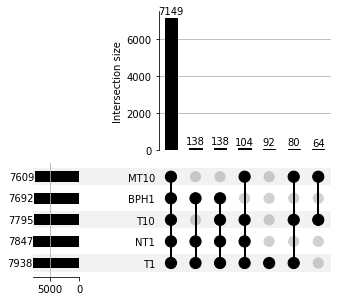

In [101]:
grouped = filtered.groupby([
    "sample_name",
    "bio_rep",
    "protein_ids"
]).mean()

grouped = grouped.reset_index(["bio_rep", "protein_ids"])

overlap = {}
for sample in SAMPLES:
    sample_frame = grouped.loc[sample, :]
    valid = data_processing.get_valid_counts(sample_frame, "protein_ids", 3)
    if sample == "M1":
        valid = data_processing.get_valid_counts(sample_frame, "protein_ids", 2)
    overlap[sample] = valid.protein_ids.unique()

upset_data = upsetplot.from_contents(overlap)
fig = upsetplot.UpSet(
    upset_data, sort_by='cardinality', 
    min_subset_size=50, show_counts="%d", )
fig2 = upsetplot.UpSet(
    upset_data, sort_by='cardinality', orientation="vertical", 
    min_subset_size=50, show_counts="%d",
    show_percentages=True)
fig.plot()
# plt.savefig("./figures/Quantif_Proteins.svg")

In [102]:
quant = pd.DataFrame(filtered.protein_ids.drop_duplicates()).reset_index(drop=True)



for sample in SAMPLES:
    
    small = grouped.loc[sample, ["protein_ids", "bio_rep", "pg_maxlfq"]]
    if sample != "M1":
        small = data_processing.get_valid_counts(small, "protein_ids", 3)
    else:
        small = data_processing.get_valid_counts(small, "protein_ids", 2)
    small = small.reset_index()

    sample_quant = []

    for rep in small.bio_rep.unique():
        sample_quant.append(f"{sample}-{rep}_log2_int")

        run_frame = small[small.bio_rep==rep]
        run_frame = run_frame.drop(["sample_name", "bio_rep"], axis=1)
        run_frame.loc[:, f"{sample}-{rep}_log2_int"] = np.log2(run_frame.pg_maxlfq)
        run_frame = run_frame.rename(columns={"pg_maxlfq":f"{sample}-{rep}_maxlfq"})

        quant = quant.merge(run_frame, how="outer", left_on="protein_ids", right_on="protein_ids")

    sample_mean = quant[sample_quant].mean(axis=1)
    quant[f"{sample}_mean"] = sample_mean
quant

protein_ids  BPH1-1_maxlfq  BPH1-1_log2_int  BPH1-2_maxlfq  \
0         P55011   11419.228571        13.479178   11213.623729   
1         Q8N697   10776.448667        13.395594    9351.750000   
2         O75822  226544.000000        17.789432  216090.500000   
3         P36578  656146.916667        19.323659  689092.819277   
4         Q96P70   60693.777419        15.889261   60737.868132   
...          ...            ...              ...            ...   
8558      Q8WUZ0   21706.550000        14.405843   19846.300000   
8559      Q15274            NaN              NaN            NaN   
8560      Q9P003   67884.350000        16.050791  137077.000000   
8561      Q5VZF2    5630.030000        12.458927    2936.850000   
8562      P01893    9086.785000        13.149554    8902.185000   

      BPH1-2_log2_int  BPH1-3_maxlfq  BPH1-3_log2_int  BPH1_mean  \
0           13.452965   12375.952381        13.595252  13.509131   
1           13.191021    9688.060000        13.241992  13.276202   
2           17.721276  227109.000000        17.793025  17.767911   
3           19.394339  749190.643678        19.514973  19.410991   
4           15.890309   61842.700000        15.916316  15.898628   
...               ...            ...              ...        ...   
8558        14.276582   20043.500000        14.290847  14.324424   
8559              NaN            NaN              NaN        NaN   
8560        17.064627   95725.700000        16.546619  16.554012   
8561        11.520054    1455.015000        10.506818  11.495266   
8562        13.119944    8113.100000        12.986038  13.085179   

       NT1-1_maxlfq  NT1-1_log2_int  ...   T10-3_maxlfq  T10-3_log2_int  \
0      10878.906349       13.409246  ...   11957.484127       13.545626   
1      11353.273333       13.470821  ...    7273.822667       12.828498   
2     200902.000000       17.616132  ...  159132.000000       17.279864   
3     515820.692308       18.976510  ...  540978.190476       19.045211   
4      68550.458824       16.064879  ...   84630.551282       16.368891   
...             ...             ...  ...            ...             ...   
8558   18786.000000       14.197370  ...   11140.500000       13.443526   
8559    1751.145000       10.774083  ...    3736.765000       11.867574   
8560   42048.100000       15.359753  ...   15125.600000       13.884705   
8561    2776.240000       11.438917  ...    3020.836667       11.560732   
8562   18689.450000       14.189936  ...    6414.410000       12.647101   

       T10_mean  MT10-1_maxlfq  MT10-1_log2_int  MT10-2_maxlfq  \
0     13.492340   11892.088889        13.537715   11975.081818   
1     12.709052    8316.040000        13.021681    7592.005714   
2     17.308877  193267.258065        17.560238  178688.000000   
3     19.013704  549430.709677        19.067578  582300.237288   
4     16.398633   77486.048684        16.241649   83291.517949   
...         ...            ...              ...            ...   
8558  13.536577            NaN              NaN            NaN   
8559  12.005088    1608.535000        10.651532    1405.505000   
8560  14.180257   17658.600000        14.108083   21089.350000   
8561  11.228877    5519.970000        12.430445    6250.355000   
8562  12.703766    4661.930000        12.186712    2797.995000   

      MT10-2_log2_int  MT10-3_maxlfq  MT10-3_log2_int  MT10_mean  
0           13.547748   12459.007812        13.604902  13.563455  
1           12.890265    7535.805000        12.879546  12.930497  
2           17.447083  185669.206897        17.502375  17.503232  
3           19.151404  538995.000000        19.039912  19.086298  
4           16.345882   85040.930000        16.375870  16.321134  
...               ...            ...              ...        ...  
8558              NaN            NaN              NaN        NaN  
8559        10.456873    1281.189500        10.323268  10.477224  
8560        14.364227   30710.900000        14.906463  14.459591  
8561        12.6097

In [103]:
final_quant = quant.dropna().reset_index(drop=True)
final_quant

protein_ids  BPH1-1_maxlfq  BPH1-1_log2_int  BPH1-2_maxlfq  \
0         P55011   11419.228571        13.479178   11213.623729   
1         Q8N697   10776.448667        13.395594    9351.750000   
2         O75822  226544.000000        17.789432  216090.500000   
3         P36578  656146.916667        19.323659  689092.819277   
4         Q96P70   60693.777419        15.889261   60737.868132   
...          ...            ...              ...            ...   
7144      Q86TS9    2104.104000        11.038990    1830.065000   
7145      Q9Y6A9   48083.500000        15.553254   49658.450000   
7146      Q9P003   67884.350000        16.050791  137077.000000   
7147      Q5VZF2    5630.030000        12.458927    2936.850000   
7148      P01893    9086.785000        13.149554    8902.185000   

      BPH1-2_log2_int  BPH1-3_maxlfq  BPH1-3_log2_int  BPH1_mean  \
0           13.452965   12375.952381        13.595252  13.509131   
1           13.191021    9688.060000        13.241992  13.276202   
2           17.721276  227109.000000        17.793025  17.767911   
3           19.394339  749190.643678        19.514973  19.410991   
4           15.890309   61842.700000        15.916316  15.898628   
...               ...            ...              ...        ...   
7144        10.837679    1764.075000        10.784696  10.887122   
7145        15.599752   53014.550000        15.694101  15.615702   
7146        17.064627   95725.700000        16.546619  16.554012   
7147        11.520054    1455.015000        10.506818  11.495266   
7148        13.119944    8113.100000        12.986038  13.085179   

       NT1-1_maxlfq  NT1-1_log2_int  ...   T10-3_maxlfq  T10-3_log2_int  \
0      10878.906349       13.409246  ...   11957.484127       13.545626   
1      11353.273333       13.470821  ...    7273.822667       12.828498   
2     200902.000000       17.616132  ...  159132.000000       17.279864   
3     515820.692308       18.976510  ...  540978.190476       19.045211   
4      68550.458824       16.064879  ...   84630.551282       16.368891   
...             ...             ...  ...            ...             ...   
7144    2333.454000       11.188251  ...    1578.175000       10.624041   
7145   41080.650000       15.326171  ...   73713.750000       16.169646   
7146   42048.100000       15.359753  ...   15125.600000       13.884705   
7147    2776.240000       11.438917  ...    3020.836667       11.560732   
7148   18689.450000       14.189936  ...    6414.410000       12.647101   

       T10_mean  MT10-1_maxlfq  MT10-1_log2_int  MT10-2_maxlfq  \
0     13.492340   11892.088889        13.537715   11975.081818   
1     12.709052    8316.040000        13.021681    7592.005714   
2     17.308877  193267.258065        17.560238  178688.000000   
3     19.013704  549430.709677        19.067578  582300.237288   
4     16.398633   77486.048684        16.241649   83291.517949   
...         ...            ...              ...            ...   
7144  10.976372    2199.485000        11.102950    2332.155000   
7145  16.175737   82258.950000        16.327885   77418.450000   
7146  14.180257   17658.600000        14.108083   21089.350000   
7147  11.228877    5519.970000        12.430445    6250.355000   
7148  12.703766    4661.930000        12.186712    2797.995000   

      MT10-2_log2_int  MT10-3_maxlfq  MT10-3_log2_int  MT10_mean  
0           13.547748   12459.007812        13.604902  13.563455  
1           12.890265    7535.805000        12.879546  12.930497  
2           17.447083  185669.206897        17.502375  17.503232  
3           19.151404  538995.000000        19.039912  19.086298  
4           16.345882   85040.930000        16.375870  16.321134  
...               ...            ...              ...        ...  
7144        11.187448    2872.355000        11.488018  11.259472  
7145        16.240390   86411.550000        16.398937  16.322404  
7146        14.364227   30710.900000        14.906463  14.459591  
7147        12.6097

In [127]:
quant_columns = [c for c in quant.columns if re.search("log2", c)]
print(quant_columns)
from scipy import stats 
def map_anova(row):
    comparisons = []
    for sample in SAMPLES:
        group_columns = [c for c in row.index if re.search(sample, c) and
                         re.search("log2", c)]
        comparisons.append(group_columns)
    stat, p = stats.f_oneway(
        row[comparisons[0]],
        row[comparisons[1]],
        row[comparisons[2]],
        row[comparisons[3]],
        row[comparisons[4]],
        # row[comparisons[5]],
        )
    
    return p

final_quant["anova"] = final_quant.apply(map_anova, axis=1)

['BPH1-1_log2_int', 'BPH1-2_log2_int', 'BPH1-3_log2_int', 'NT1-1_log2_int', 'NT1-2_log2_int', 'NT1-3_log2_int', 'T1-1_log2_int', 'T1-2_log2_int', 'T1-3_log2_int', 'T10-1_log2_int', 'T10-2_log2_int', 'T10-3_log2_int', 'MT10-1_log2_int', 'MT10-2_log2_int', 'MT10-3_log2_int']


In [316]:
mean_cols = [c for c in final_quant.columns if re.search("mean", c)]
diff = final_quant[mean_cols].max(axis=1) - final_quant[mean_cols].min(axis=1)
final_quant["global_max_change"] = diff

In [198]:
df_corr = quant.fillna(0)[quant_columns].corr()
df_corr = df_corr.reset_index().melt("index")

alt.Chart(df_corr).mark_rect().encode(
    x=alt.X("index:N", title="", sort=bcap_order),
    y=alt.Y("variable:N", title="", sort=bcap_order),
    color=alt.Color("value:Q", 
                    scale=alt.Scale(
                        # scheme="blues",
                        range = ["#FFFFFF", BLUE, DARK_BLUE],
                        domain=[0.7, 1],
                    ))
)
# df_corr

alt.Chart(...)

In [106]:
small_quant = ['BPH1-1_log2_int',
 'BPH1-2_log2_int',
 'BPH1-3_log2_int',
 'NT1-1_log2_int',
 'NT1-2_log2_int',
 'NT1-3_log2_int',
 'T1-1_log2_int',
 'T1-2_log2_int',
 'T1-3_log2_int',
 'T10-1_log2_int',
 'T10-2_log2_int',
 'T10-3_log2_int',
#  'M1-1_log2_int',
#  'M1-2_log2_int',
 'MT10-1_log2_int',
 'MT10-2_log2_int',
 'MT10-3_log2_int'
]

Final Max Distance: 24


c:\Users\graha\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


1597 significant proteins
Cluster 1 has 445 proteins
Cluster 2 has 257 proteins
Cluster 3 has 69 proteins
Cluster 4 has 417 proteins
Cluster 5 has 185 proteins
Cluster 6 has 224 proteins


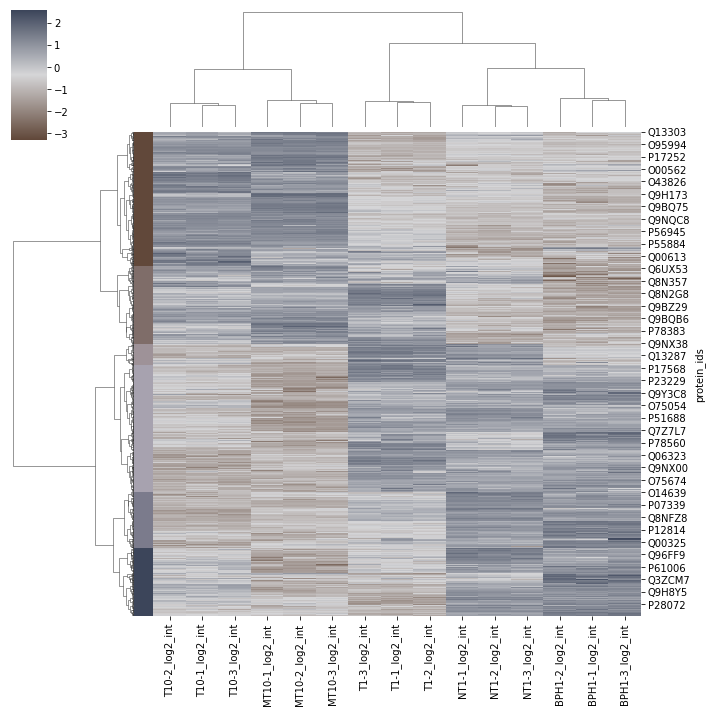

In [323]:
from scipy.cluster import hierarchy
import seaborn as sns 

sig = final_quant[(final_quant.anova<=0.005)][["protein_ids"]+ small_quant]
sig = final_quant[(final_quant.anova<=0.05) & (final_quant.global_max_change >= 1)][["protein_ids"]+ small_quant]

sig.set_index('protein_ids', inplace=True)

# zscore the data to match the seaborn output
sig_data = stats.zscore(sig, axis=1)

# determine row clustering
row_linkage = hierarchy.linkage(hierarchy.distance.pdist(sig_data), method='ward')

# plot the dendrogram, changing values to determine optimal grouping
# data_processing.fancy_dendrogram(row_linkage, p=60, truncate_mode='lastp', annotate_above=100, max_d=max_d)

# once the correct distance is determined, plug in here
max_d = 20
s = hierarchy.fcluster(row_linkage, max_d, criterion='distance')
while len(list(set(s))) > 6:
    max_d += 1
    s = hierarchy.fcluster(row_linkage, max_d, criterion='distance')
print(f"Final Max Distance: {max_d}")


keys = sorted(list(set(s)))
colors = generate_hex.generate_colors([BROWN, BLUE_GRAY, DARK_BLUE], len(keys))
color_map = dict(zip(keys, colors))
t = np.array([color_map.get(i, 'k') for i in s])

# create heatmap colors
long_colors = generate_hex.generate_colors([BROWN, "#DDDDDD", DARK_BLUE], 40)
mycmap = ListedColormap(long_colors, name="blastoise")
c = mycmap(np.linspace(0, 1, 3))
first = np.linspace(c[0], c[1], 128)
second = np.linspace(c[1], c[2], 128)

mcp = ListedColormap(np.vstack([first, second]))

res = sns.clustermap(sig, z_score=0, figsize=(10,10), row_linkage=row_linkage,  dendrogram_ratio=0.2, row_colors=t, cmap=mcp)

sig_data.loc[:, 'cluster'] = s
print(f'{len(sig_data)} significant proteins')

# sns.clustermap(sig[quant_columns], z_score=0)

clust_counts = sig_data.cluster.value_counts().sort_index()
for i, val in enumerate(clust_counts, start=1):
    print(f"Cluster {i} has {val} proteins")


In [321]:
line_data = sig_data.reset_index().melt(["protein_ids", "cluster"])
line_data.loc[:, "variable"] = line_data.variable.map(lambda x: x.split("_")[0])

expression_lines = alt.Chart(line_data).mark_line(
    opacity=0.1
).encode(
    x=alt.X("variable:N",sort=bcap_order,
            axis=co.alt_axis),
    y=alt.Y("value:Q", title="z-score",
            axis=co.alt_axis),
    color=alt.Color("cluster:Q", legend=None,
                    scale=alt.Scale(range=colors)),
    row="cluster:Q",
    detail="protein_ids"
).properties(height=100, width=300)

expression_lines

alt.Chart(...)

In [339]:
cluster_data = sig_data.reset_index()
prots = cluster_data[cluster_data.cluster==6].protein_ids.to_clipboard(header=False, index=False)

In [336]:
pca_in = sig_data.drop("cluster", axis=1)
labels = pca_in.columns.map(lambda x: x.split("_")[0])
labels = labels.map(lambda x: x.split('-')[0])
from sklearn import decomposition

pca = decomposition.PCA(2)
pca_out = pca.fit_transform(pca_in.T)
x, y = pca_out[:, 0], pca_out[:, 1]

pc1, pc2 = pca.explained_variance_ratio_

pca_data = pd.DataFrame({
    "x":x,
    "y":y,
    "label":labels
})

alt.Chart(pca_data).mark_circle(
    size=50,
    opacity=1
).encode(
    x=alt.X("x:Q", title=f"PC1 {pc1:.1%}",
        axis=co.alt_axis),
    y=alt.Y("y:Q", title=f"PC2 {pc2:.1%}",
        axis=co.alt_axis),
    color=alt.Color("label",
                    scale=alt.Scale(
                        domain=SAMPLES,
                        range=colors
                    ))
).configure_axis(
    titleFontSize=14
)

alt.Chart(...)

In [261]:
go_files = data_processing.get_files("./data/Metascape/")

go_data = pd.DataFrame()
for file in go_files:
    cluster = re.search(r"_(\d)\.", file).group(1)
    go_frame = pd.read_excel(file, sheet_name="Enrichment")
    go_frame = go_frame[go_frame.GroupID.str.contains('Summary')]
    go_frame = go_frame.iloc[:5, :]
    go_frame.loc[:, "LogP"] = go_frame.LogP * -1
    go_frame.loc[:, "cluster"] = cluster
    go_frame = go_frame[["Term", "Description", "LogP", "cluster"]]
    
    go_data = pd.concat([go_data, go_frame]).reset_index(drop=True)

y_axis = co.alt_axis.copy()
y_axis["orient"] = "right"
y_axis["labelLimit"] = 500

go_plot = alt.Chart(go_data).mark_bar().encode(
    x=alt.X("LogP:Q", title="-10Log(P)",
        axis=co.alt_axis),
    y=alt.Y("Description:N", title="", sort="-x",
        axis=y_axis),
    color=alt.Color("cluster:N",
        scale=alt.Scale(
            range=colors
        )),
    row="cluster:N"
).properties(
    width=200
).resolve_scale(y="independent")

In [262]:
expression_lines | go_plot

alt.HConcatChart(...)

In [280]:
proteins = final_quant.protein_ids.tolist()

chunks = [proteins[i:i+500] for i in range(0, len(proteins), 500)]

genes = dict()

for c in chunks:
    resp = uniprot.send_accessions(c)
    ans = uniprot.parse_response(resp, "gene")
    genes.update(ans)

1 gene(s) were not mapped!


In [283]:
final_quant.loc[:, "gene"] = final_quant.protein_ids.map(genes)
final_quant.head()

protein_ids  BPH1-1_maxlfq  BPH1-1_log2_int  BPH1-2_maxlfq  BPH1-2_log2_int  \
0      P55011   11419.228571        13.479178   11213.623729        13.452965   
1      Q8N697   10776.448667        13.395594    9351.750000        13.191021   
2      O75822  226544.000000        17.789432  216090.500000        17.721276   
3      P36578  656146.916667        19.323659  689092.819277        19.394339   
4      Q96P70   60693.777419        15.889261   60737.868132        15.890309   

   BPH1-3_maxlfq  BPH1-3_log2_int  BPH1_mean   NT1-1_maxlfq  NT1-1_log2_int  \
0   12375.952381        13.595252  13.509131   10878.906349       13.409246   
1    9688.060000        13.241992  13.276202   11353.273333       13.470821   
2  227109.000000        17.793025  17.767911  200902.000000       17.616132   
3  749190.643678        19.514973  19.410991  515820.692308       18.976510   
4   61842.700000        15.916316  15.898628   68550.458824       16.064879   

   ...   T10_mean  MT10-1_maxlfq  MT10-1_log2_int  MT10-2_maxlfq  \
0  ...  13.492340   11892.088889        13.537715   11975.081818   
1  ...  12.709052    8316.040000        13.021681    7592.005714   
2  ...  17.308877  193267.258065        17.560238  178688.000000   
3  ...  19.013704  549430.709677        19.067578  582300.237288   
4  ...  16.398633   77486.048684        16.241649   83291.517949   

   MT10-2_log2_int  MT10-3_maxlfq  MT10-3_log2_int  MT10_mean         anova  \
0        13.547748   12459.007812        13.604902  13.563455  8.530960e-02   
1        12.890265    7535.805000        12.879546  12.930497  1.040791e-01   
2        17.447083  185669.206897        17.502375  17.503232  1.043079e-03   
3        19.151404  538995.000000        19.039912  19.086298  6.413665e-08   
4        16.345882   85040.930000        16.375870  16.321134  1.228864e-02   

      gene  
0  SLC12A2  
1  SLC15A4  
2    EIF3J  
3     RPL4  
4     IPO9  

[5 rows x 38 columns]

In [332]:
final_quant[(final_quant.anova <= 0.05)&(final_quant.gene.str.contains("SLC"))].gene.tolist()
sig_proteins = sig_data.reset_index()["protein_ids"]

sig_quant = final_quant[final_quant.protein_ids.isin(sig_proteins)]
sig_quant[sig_quant.gene=="STAT2"][mean_cols]

BPH1_mean   NT1_mean    T1_mean   T10_mean  MT10_mean
1987  13.594168  14.435081  14.299579  13.614981  12.990775

In [315]:
mean_cols = [c for c in final_quant.columns if re.search("mean",c)]
diff = final_quant[mean_cols].max(axis=1) - final_quant[mean_cols].min(axis=1)
changed = diff[diff>=1]

final_quant.iloc[changed.index, :]

protein_ids  BPH1-1_maxlfq  BPH1-1_log2_int  BPH1-2_maxlfq  \
1         Q8N697   10776.448667        13.395594    9351.750000   
11        P51788    2437.852857        11.251395    2756.603333   
18        A6NIH7   97068.054545        16.566709   60505.750000   
19        Q9Y2U8   37435.451724        15.192118   36956.746667   
30        Q92922   56066.235294        15.774845   51035.977143   
...          ...            ...              ...            ...   
7140      Q3KRA9    5824.580000        12.507938    5095.205000   
7143      Q9Y3B6    3875.450000        11.920148    4257.540000   
7146      Q9P003   67884.350000        16.050791  137077.000000   
7147      Q5VZF2    5630.030000        12.458927    2936.850000   
7148      P01893    9086.785000        13.149554    8902.185000   

      BPH1-2_log2_int  BPH1-3_maxlfq  BPH1-3_log2_int  BPH1_mean  \
1           13.191021    9688.060000        13.241992  13.276202   
11          11.428676    2136.240000        11.060858  11.246976   
18          15.884785   85925.350000        16.390796  16.280763   
19          15.173550   36437.785227        15.153148  15.172938   
30          15.639227   51361.556944        15.648401  15.687491   
...               ...            ...              ...        ...   
7140        12.314924    6701.590000        12.710288  12.511050   
7143        12.055804    4909.945000        12.261491  12.079148   
7146        17.064627   95725.700000        16.546619  16.554012   
7147        11.520054    1455.015000        10.506818  11.495266   
7148        13.119944    8113.100000        12.986038  13.085179   

       NT1-1_maxlfq  NT1-1_log2_int  ...   T10_mean  MT10-1_maxlfq  \
1      11353.273333       13.470821  ...  12.709052    8316.040000   
11      2029.468571       10.986886  ...  11.162141    2393.804000   
18    101103.650000       16.625476  ...  16.878817  113579.000000   
19     36307.350000       15.147974  ...  14.269182   21405.896774   
30     58558.550000       15.837592  ...  15.342355   27069.755102   
...             ...             ...  ...        ...            ...   
7140    6013.845000       12.554072  ...  12.005035    2666.360000   
7143    4533.440000       12.146390  ...  11.503756    1801.160000   
7146   42048.100000       15.359753  ...  14.180257   17658.600000   
7147    2776.240000       11.438917  ...  11.228877    5519.970000   
7148   18689.450000       14.189936  ...  12.703766    4661.930000   

      MT10-1_log2_int  MT10-2_maxlfq  MT10-2_log2_int  MT10-3_maxlfq  \
1           13.021681    7592.005714        12.890265    7535.805000   
11          11.225089    2175.630000        11.087218    1843.875000   
18          16.793337  100958.250000        16.623399  130853.500000   
19          14.385721   21301.209524        14.378648   22101.924615   
30          14.724394   23738.892308        14.534965   25709.076923   
...               ...            ...              ...            ...   
7140        11.380656    2710.190000        11.404178    3082.820000   
7143        10.814711    1809.670000        10.821511    2140.295000   
7146        14.108083   21089.350000        14.364227   30710.900000   
7147        12.430445    6250.355000        12.609722    5658.305000   
7148        12.186712    2797.995000        11.450178    3518.730000   

      MT10-3_log2_int  MT10_mean     anova     gene  
1           12.879546  12.930497  0.104079  SLC15A4  
11          10.848525  11.053611  0.477006    CLCN2  
18          16.997593  16.804776  0.274856  UNC119B  
19          14.431884  14.398751  0.004207    LEMD3  
30          14.649990  14.636450  0.006775  SMARCC1  
...               ...        ...       ...      ...  
7140        11.590035  11.458290  0.002026   ALKBH6  
7143        11.063594  10.899938  0.001594     EMC9  
7146        14.906463  14.459591  0.006393    CNIH4  
7147        12.466154  12.502107  0.170458    MBNL2  
7148        11.780839  11.805909  0.073930    HLA-H  

[2239 rows x 38 columns]

In [296]:
test = df.dropna()
test[test.genes.str.contains("SLC7")].genes.drop_duplicates().tolist()

['SLC7A5', 'SLC7A1', 'SLC7A6', 'SLC7A11', 'SLC7A4', 'SLC7A6OS', 'SLC7A8']

In [291]:
final_quant[final_quant.gene.str.contains("SLC7")]

protein_ids  BPH1-1_maxlfq  BPH1-1_log2_int  BPH1-2_maxlfq  \
2749      Q01650   53855.153846        15.716797   59041.679167   
4264      P30825   26557.786667        14.696847   27803.053333   
5869      Q92536    2715.418000        11.406959    4792.946667   
7038      Q96CW6    3292.000000        11.684749    4399.830000   

      BPH1-2_log2_int  BPH1-3_maxlfq  BPH1-3_log2_int  BPH1_mean  \
2749        15.849446   69148.350000        16.077407  15.881217   
4264        14.762956   32908.566667        15.006176  14.821993   
5869        12.226697    4250.546000        12.053432  11.895696   
7038        12.103232    4010.144000        11.969438  11.919140   

      NT1-1_maxlfq  NT1-1_log2_int  ...   T10_mean  MT10-1_maxlfq  \
2749  56485.776000       15.785600  ...  16.487430  149014.760000   
4264  39511.200000       15.269974  ...  14.826945   53655.513333   
5869   4556.642857       12.153756  ...  11.197323    4058.815000   
7038   4278.980000       12.063051  ...  11.838658    3461.260000   

      MT10-1_log2_int  MT10-2_maxlfq  MT10-2_log2_int  MT10-3_maxlfq  \
2749        17.185096     152884.080        17.222079      157036.84   
4264        15.711439      54250.950        15.727361       56201.50   
5869        11.986843       3627.495        11.824758        5309.11   
7038        11.757082       2971.582        11.537015        2789.58   

      MT10-3_log2_int  MT10_mean     anova      gene  
2749        17.260744  17.222639  0.001853    SLC7A5  
4264        15.778321  15.739040  0.122372    SLC7A1  
5869        12.374254  12.061952  0.443133    SLC7A6  
7038        11.445832  11.579976  0.265537  SLC7A6OS  

[4 rows x 38 columns]

In [300]:
test[test.genes.str.contains("SLC7A11")].run.value_counts()

BCaP_MT10-3_run1_1_1_950    8
BCaP_T10-2_run2_1_1_939     7
BCaP_T10-1_run1_1_1_935     7
BCaP_T10-3_run1_1_1_941     7
BCaP_T10-2_run1_1_1_938     7
BCaP_MT10-3_run2_1_1_951    7
BCaP_T10-1_run2_1_1_936     7
BCaP_MT10-2_run2_1_1_948    7
BCaP_MT10-2_run1_1_1_947    7
BCaP_MT10-1_run2_1_1_945    7
BCaP_MT10-1_run1_1_1_944    7
BCaP_T10-3_run2_1_1_942     6
BCaP_T1-3_run1_1_1_932      6
BCaP_T1-1_run2_1_1_927      5
BCaP_T1-3_run2_1_1_933      5
BCaP_NT1-3_run1_1_1_923     5
BCaP_NT1-2_run1_1_1_920     4
BCaP_NT1-2_run2_1_1_921     4
BCaP_T1-1_run1_1_1_926      4
BCaP_T1-2_run1_1_1_929      4
BCaP_BPH1-1_run1_1_1_908    3
BCaP_NT1-1_run1_1_1_917     3
BCaP_T1-2_run2_1_1_930      3
BCaP_BPH1-3_run1_1_1_914    2
BCaP_BPH1-2_run2_1_1_912    2
BCaP_NT1-3_run2_1_1_924     2
BCaP_NT1-1_run2_1_1_918     2
BCaP_BPH1-2_run1_1_1_911    2
BCaP_BPH1-3_run2_1_1_915    1
BCaP_BPH1-1_run2_1_1_909    1
Name: run, dtype: int64

In [286]:
final_quant.loc[final_quant.gene.isna(), "gene"] = "gene_missing"